In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)

### Neural Network with three hidden layers
The number of input layer neurons have to be same as the number of input features. In this case my dataset FanSpeedDS has five features, so there are five inputLayerNeurons.
For three hidden layers, a suitable number of nuerons have been selectet.
The number of output layer neurons have to be the same as the number of output classes. In this case. There are five output classes (1 to 5). So threre are five outputLayerNeurons.

Four weight matrices have been randomly initialized,
W_IH1 is from input layer neurons to hidden layer 1 neurons
W_H12 if from hidden layer 1 neurons to hidden layer 2 neurons
W_H23 is from hidden layer 2 neurons to hidden layer 3 neurons
W_H3O is from hidden layer 3 neurons to output layer neurons

feedForward function has been adjusted to get the output of every hidden layer and the output layer via sigmoid function. The output from the output layer neurons are the prediction.

For backPropagation function every weight is being updated by introducing hidden_delta for eache output layer and they travels backwards from the output layer weight matrix to the hidden layer 1 weight matrix.

In [2]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 5
        hiddenLayer1Neurons = 16
        hiddenLayer2Neurons = 32
        hiddenLayer3Neurons = 16
        outputLayerNeurons = 5

        self.W_IH1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_H12 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_H23 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_H3O = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)
        self.learning_rate = 0.01

    def sigmoid(self, x, der=False):
        if der == True:
          return x * (1 - x)
        else:
          return 1 / (1 + np.exp(-x))

    # Forward propagation to the parediction
    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_IH1)
        self.hidden1_output = self.sigmoid(hidden1_input)  # Getting output from hidden layer 1 neurons

        hidden2_input = np.dot(self.hidden1_output, self.W_H12)
        self.hidden2_output = self.sigmoid(hidden2_input)  # Getting output from hidden layer 2 neurons

        hidden3_input = np.dot(self.hidden2_output, self.W_H23)
        self.hidden3_output = self.sigmoid(hidden3_input) # Getting output from hidden layer 3 neurons

        output_input = np.dot(self.hidden3_output, self.W_H3O)
        pred = self.sigmoid(output_input) # Getting output from output layers

        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred # Error from the final output
        output_delta = output_error * self.learning_rate * self.sigmoid(pred, True)

        hidden3_error = output_delta.dot(self.W_H3O.T)  # Error from the hidden layer3
        hidden3_delta = hidden3_error * self.learning_rate * self.sigmoid(self.hidden3_output, True)

        hidden2_error = hidden3_delta.dot(self.W_H23.T) # Error from the hidden layer2
        hidden2_delta = hidden2_error * self.learning_rate * self.sigmoid(self.hidden2_output, True)

        hidden1_error = hidden2_delta.dot(self.W_H12.T) # Error from the hidden layer1
        hidden1_delta = hidden1_error * self.learning_rate * self.sigmoid(self.hidden1_output, True)

        # Adjusting the weights
        self.W_H3O += self.hidden3_output.T.dot(output_delta)
        self.W_H23 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_H12 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_IH1 += X.T.dot(hidden1_delta)


    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
try:
    df = pd.read_csv('FanSpeedDS.csv')
    X = df[['temp', 'cpu', 'memory', 'disk', 'network']].values
    Y_labels = df[['fanspeed']].values.astype(int) # Ensure labels are integers

    # Manual Min-Max Scaling for input features
    X_min = X.min(axis=0, keepdims=True)
    X_max = X.max(axis=0, keepdims=True)
    X_scaled = (X - X_min) / (X_max - X_min + 1e-8)

    # Adjust labels to be 0-indexed (0 to num_classes - 1)
    Y_labels_adjusted = Y_labels - 1
    num_classes = len(np.unique(Y_labels_adjusted))
    Y_onehot = np.eye(num_classes)[Y_labels_adjusted.flatten()]

except FileNotFoundError:
    print("Error: 'FanSpeedDS.csv' not found. Please upload the CSV file.")
    exit()

In [5]:
df.head()

,temp,cpu,memory,disk,network,fanspeed
0,82,66,76,42,79,5
1,83,95,61,66,52,5
2,76,24,95,77,25,4
3,77,68,31,38,43,4
4,77,23,85,44,88,4


Train validation split the dataset (sklearn have only been used for train val split and ROC curve)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_onehot, test_size=0.2, random_state=42)


Here we can see that both training and validation errors start at quite high levels, indicating the poor performance of the model initially. As training progresses over 10,000 epochs, the training error slowly reduces, indicating the fact that the model is learning to fit the training data better. The validation error also reduces, albeit more slowly, which indicates the model's increasing ability to generalize to new, unseen data. Interestingly, the validation error never increases at any point, meaning that the model is not overfitting and maintaining good generalization while training. The steady decline in both errors suggests a consistent and good learning process. However, since the improvement rate of the validation error slows down over time, similar performance would likely be achieved using fewer epochs through the application of early stopping, which would save training time without sacrificing accuracy.

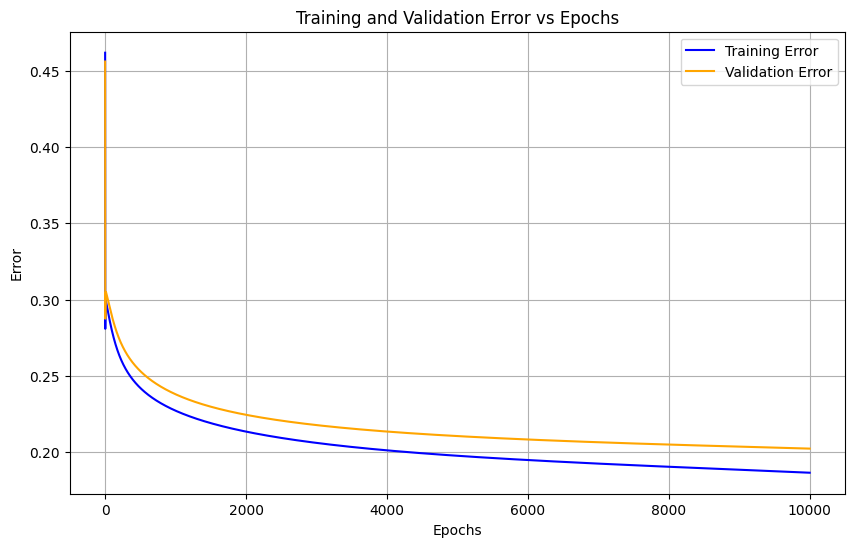

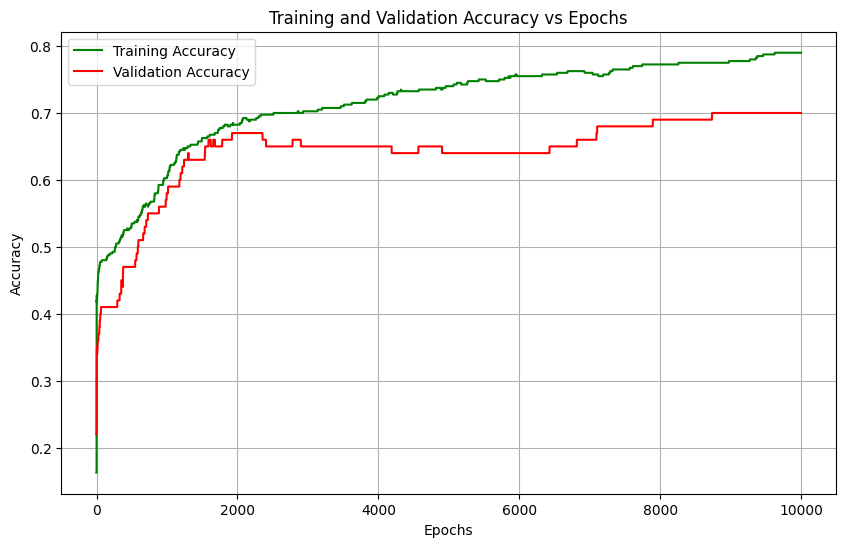

In [7]:
NN = NeuralNetwork()

train_err = []
val_err = []
train_acc = []
val_acc = []

for i in range(10000):
    NN.train(X_train, Y_train)

    # Training predictions and metrics
    train_output = NN.feedForward(X_train)
    train_loss = np.mean(np.abs(Y_train - train_output))
    train_err.append(train_loss)

    train_preds = np.argmax(train_output, axis=1)
    train_true = np.argmax(Y_train, axis=1)
    train_accuracy = np.mean(train_preds == train_true)
    train_acc.append(train_accuracy)

    # Validation predictions and metrics
    val_output = NN.feedForward(X_val)
    val_loss = np.mean(np.abs(Y_val - val_output))
    val_err.append(val_loss)

    val_preds = np.argmax(val_output, axis=1)
    val_true = np.argmax(Y_val, axis=1)
    val_accuracy = np.mean(val_preds == val_true)
    val_acc.append(val_accuracy)

# Plotting error
plt.figure(figsize=(10, 6))
plt.plot(train_err, label="Training Error", color="blue")
plt.plot(val_err, label="Validation Error", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Training and Validation Error vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label="Training Accuracy", color="green")
plt.plot(val_acc, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()



Show the predicted calss and ground truth

In [8]:
top_50_df = pd.DataFrame({'Actual': val_true[:50], 'Predicted': val_preds[:50]})  # Taking top 50 for display

def color_mismatch(val):
    color = ['color: red;' if val['Actual'] != val['Predicted'] else 'color: black;'] * len(val)
    return pd.Series(color, index=val.index)

styled_df = top_50_df.style.apply(color_mismatch, axis=1)
display(styled_df)

,Actual,Predicted
0,4,4
1,0,0
2,1,1
3,4,4
4,2,3
5,3,2
6,1,1
7,0,0
8,3,4
9,0,0


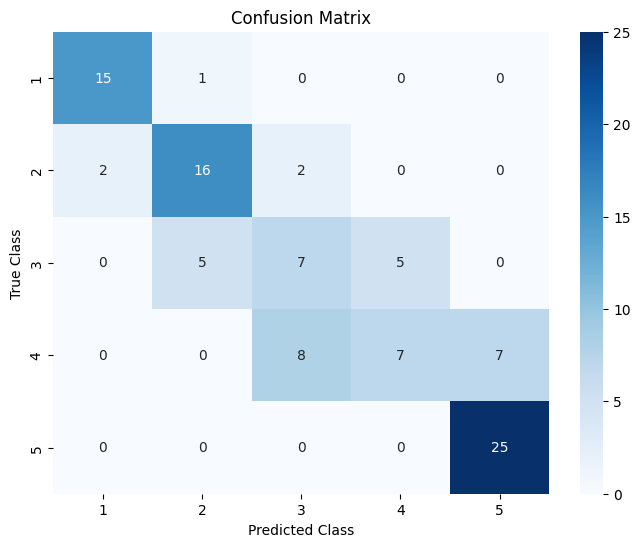

Macro-averaged F1 Score: 0.6743
Classification Report:

              precision    recall  f1-score   support

     Class 1       0.88      0.94      0.91        16
     Class 2       0.73      0.80      0.76        20
     Class 3       0.41      0.41      0.41        17
     Class 4       0.58      0.32      0.41        22
     Class 5       0.78      1.00      0.88        25

    accuracy                           0.70       100
   macro avg       0.68      0.69      0.67       100
weighted avg       0.68      0.70      0.68       100



In [9]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

val_output = NN.feedForward(X_val)
val_preds = np.argmax(val_output, axis=1)
val_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, 6), yticklabels=np.arange(1, 6))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

f1_macro = f1_score(val_true, val_preds, average='macro')
print(f"Macro-averaged F1 Score: {f1_macro:.4f}")

print("Classification Report:\n")
print(classification_report(val_true, val_preds, target_names=[f"Class {i}" for i in range(1, 6)]))


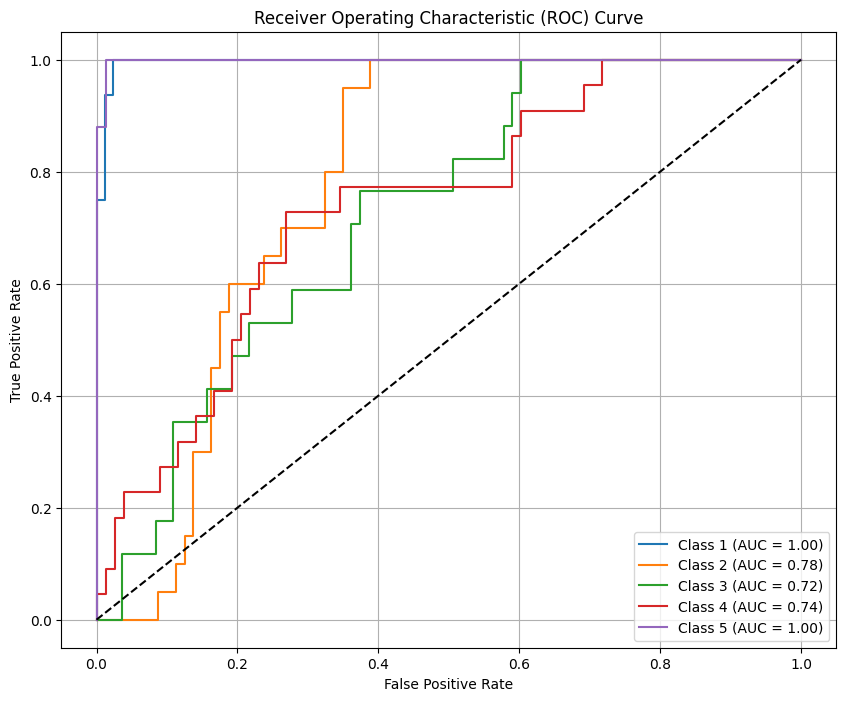

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

Y_val_binarized = label_binarize(val_true, classes=np.arange(num_classes))

val_probabilities = NN.feedForward(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val_binarized[:, i], val_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()